In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
def dmd(X, Y, truncate=None):
    from numpy.linalg import svd
    U2,Sig2,Vh2 = svd(X, False) # SVD of input matrix
    r = len(Sig2) if truncate is None else truncate # rank truncation
    U = U2[:,:r]
    Sig = np.diag(Sig2)[:r,:r]
    V = Vh2.conj().T[:,:r]
    Atil = U.conj().T @ Y @ V @ np.linalg.inv(Sig) # build A tilde
    mu,W = np.linalg.eig(Atil)
    Phi = Y @ V @ np.linalg.inv(Sig) @ W # build DMD modes
    return mu, Phi

In [3]:
filename = 'ec761078_day3_hour5.h5'
f = h5py.File(filename, 'r')

# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])

n_display_samples = 100

data = f['dataset']

d = np.array(data)
shifted_data = np.vstack((d[:,:-1],d[:,1:]))

Keys: KeysView(<HDF5 file "ec761078_day3_hour5.h5" (mode r)>)


In [4]:
dt = 1e-3 # 1 / sampling frequency 
n_samples = 5000
μ,Phi = dmd(shifted_data[:,:n_samples],shifted_data[:,1:n_samples+1],64)
b = np.linalg.pinv(Phi) @ (shifted_data[:,:n_samples])[:,0]
ω = np.log(μ) / dt

fs = 60 # Hz
λ1 = np.exp(2j*np.pi*fs*dt)
λ2 = np.exp(-2j*np.pi*fs*dt)
Λ = np.vstack([[λ1**_i for _i in range(n_samples)],[λ2**_i for _i in range(n_samples)]])
orthog = (np.eye(n_samples)-(np.linalg.pinv(Λ) @ Λ))

μ2,Phi2 = dmd(shifted_data[:,:n_samples] @ orthog,shifted_data[:,1:n_samples+1] @ orthog,62)
b2 = np.linalg.pinv(Phi2) @ (shifted_data[:,:n_samples] @ orthog)[:,0]
ω2 = np.log(μ2) / dt

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


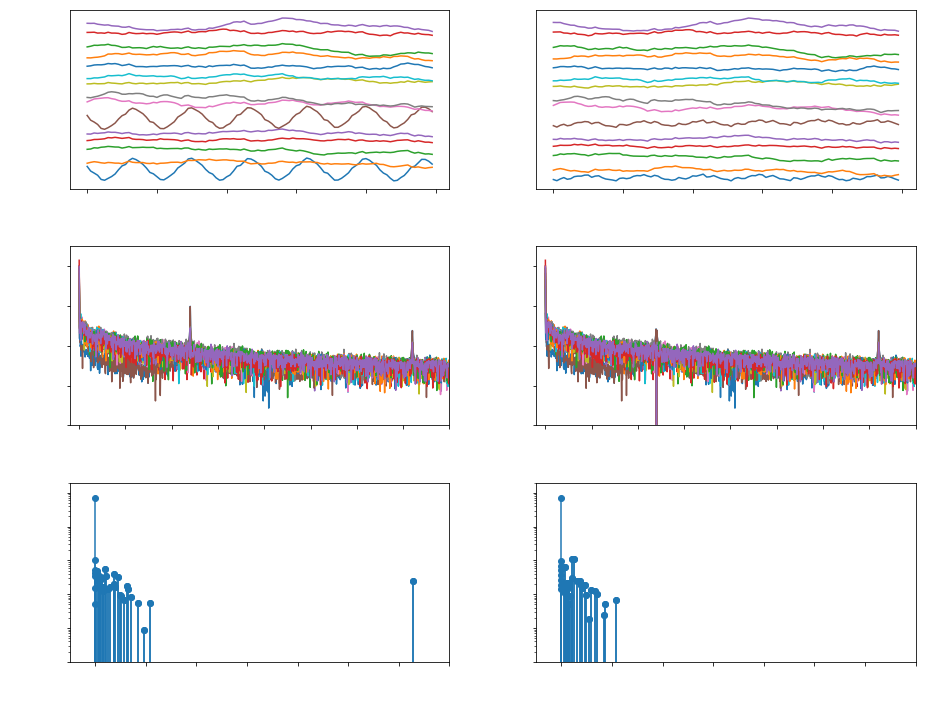

In [5]:
### Unfixed frequency

clr = 'white'
plt.figure(figsize=(13.1,10))


plt.subplot(3,2,1)
for _i,row in enumerate(d - d.mean(axis=1)[:,np.newaxis]):
    if _i < 15:
        plt.plot(dt*np.arange(n_display_samples),row[:n_display_samples]+_i*100)
    plt.yticks([])
plt.ylabel('Voltage',fontsize=18,color=clr)
plt.xlabel('Time [s]',fontsize=18,color=clr)

plt.subplot(3,2,2)
for _i,row in enumerate(shifted_data[:,:n_samples] @ orthog - shifted_data.mean(axis=1)[:,np.newaxis]):
    if _i < 15:
        plt.plot(dt*np.arange(n_display_samples),row[:n_display_samples]+_i*100)
    plt.yticks([])
plt.ylabel('Voltage',fontsize=18,color=clr)
plt.xlabel('Time [s]',fontsize=18,color=clr)

plt.subplot(3,2,3)
data = shifted_data[:,:n_samples] 
x̂ = np.fft.fft(data)
xpower = np.abs(x̂[:,:n_samples//2+1]) * 2 / n_samples
Fs=1000
freqs = Fs*np.arange(n_samples//2+1)/n_samples

for _i,row in enumerate(xpower):
    if _i < 15:
        plt.plot(freqs,row)
plt.yscale('log')
plt.ylim([1e-4,1e5])
plt.xlim([-5,200])
plt.xlabel('Frequency [Hz]',fontsize=18,color=clr)
plt.ylabel('Power',fontsize=18,color=clr)

plt.subplot(3,2,4)

x̂ = np.fft.fft(shifted_data[:,:n_samples] @ orthog)
xpower = np.abs(x̂[:,:n_samples//2+1]) * 2 / n_samples
Fs=1000
freqs = Fs*np.arange(n_samples//2+1)/n_samples

for _i,row in enumerate(xpower):
    if _i < 15:
        plt.plot(freqs,row)
plt.ylim([1e-4,1e5])
plt.xlim([-5,200])
#plt.xlim([50,70])
plt.yscale('log')
plt.xlabel('Frequency [Hz]',fontsize=18,color=clr)
plt.ylabel('Power',fontsize=18,color=clr)

plt.subplot(3,2,5)
plt.ylabel('Power',fontsize=18,color=clr)
plt.xlabel('Frequency [Hz]',fontsize=18,color=clr)
# Factor of sqrt(2) from DMD page 120
plt.stem(np.abs(np.imag(ω)) /(2*np.pi),np.abs(b)*np.sqrt(2))
plt.xlim([-5,70])
plt.ylim([1,2e5])
plt.xticks(fontsize=14,color=clr)
plt.yscale('log')

plt.subplot(3,2,6)
plt.ylabel('Power',fontsize=18,color=clr)
plt.xlabel('Frequency [Hz]',fontsize=18,color=clr)
#plt.xlim([-70,70])
plt.xlim([-5,70])
plt.ylim([1,2e5])

# Factor of sqrt(2) from DMD page 120
plt.stem(np.abs(np.imag(ω2))/(2*np.pi),np.abs(b2)*np.sqrt(2))
plt.yscale('log')

for _k in range(1,7):
    plt.subplot(3,2,_k)
    plt.xticks(fontsize=14,color=clr)
    plt.yticks(fontsize=14,color=clr)

plt.tight_layout()

plt.show()